# SN Ia Hubble residuals Correleated with Local Stellar Populations

*This is work that will be presented at AAS 229th meeting in TX on January 7th, 2017*

-------

TITLE: Correlations Between Hubble Residuals and Local Stellar Populations of Type Ia Supernovae

Abstract: There appears to be correlations between SN Ia Hubble diagram residuals and host galaxy mass, metallicity, and star formation history. An uncorrected bias may produce a systematic offset in cosmological measurements. Rigault et al. (2013) found that the local environment can correlate with Hubble residuals and possibly impact precision Hubble Constant measurements. Global properties are the luminosity average of local environments, therefore the properties of local environments may hold stronger correlations than their global counterparts. We analyze host galaxies from the SDSS-II survey using both ground-based and Hubble Space Telescope imaging. We generate local stellar environmental properties by selecting a best fit Flexible Stellar Population Synthesis model that matches the SDSS Scene Modeling data. The derived properties, such as metallicity, stellar age, and star formation history, are then compared to the SN Ia's Hubble residual in the search for correlations.

-------

Holtzman et al. (2008, arXiv:0908.4277) performed a Scene Modeling Photometry of SDSS SN Ia host galaxies. **Are these results apparent or absolute frame?** Local stellar populations can be modeled via FSPS (Conroy 2009, Conroy 2010, 10.5281/zenodo.12157). Sellecting the correct model varrient, can be done via minimizing a chi-square via emcee (arXiv:1202.3665). From each SMP's `ugriz` we can get a SFH, metallicity, age, etc.

Values from SALT2 and MLCS2k2, CMB redshift, etc. are available from Sako (2014, arXiv:1401.3317) table 1. But we may want to use Campbell 2013's values. I am not sure if we have HR's or if we need to calculate them. 

We can easily check color and vlues of Pegase for any relationships with the aformationed SN values. 


In [1]:
import re
import warnings
from glob import glob
from copy import deepcopy
from datetime import datetime

import numpy as np
import pandas as pd
from astropy.io import fits

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#for "FSPS"
import fsps

In [3]:
#for "Finding Correct Model"
from scipy.optimize import minimize

In [4]:
#for "Comparing Varriables"
from scipy import integrate
# from astropy.cosmology import WMAP9 as cosmo   # or make my own
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.27) ## Kessler 2009a but flat and 2-sig figs (Gupta 2011, §2.3)

------

# Cut Holtzman 2008 SMP data

I need to provide cuts to this data. We do not need over 10,000 objects! Not all of these are Ia's! Holtzman (2008) abstract only says there are 146 SN Ia.

Lets use the ~1000 SN Ia from Campbell (2013), `data/SDSS_Photometric_SNe_Ia.fits`. This is more then Holtzman's 146 because Campbell also included photometrically classified SN Ias. If this does not work then we can use the SDSS-II SN list (from website), `data/snlist.dat.txt`.

In [5]:
#note that data is in second header, `cause Yeah fits!
fCampbell = fits.open('data/SDSS_Photometric_SNe_Ia.fits')

#fix `ValueError: Big-endian buffer not supported on little-endian compiler`
fCampbell[1].data = fCampbell[1].data.byteswap(True).newbyteorder() 
data = deepcopy(fCampbell[1].data)  

#make data into a `DataFrame`
SNIaCam = pd.DataFrame(data)
#might not want to `set_index` since this is a column we want.
# SNIaCam.set_index('CID', inplace=True)
SNIaCam.head()

,CID,Z,Z_ERR,SN_RA,SN_DEC,GAL_RA,GAL_DEC,HOST_OBJID,X0,X0_ERR,...,COLOR_ERR,C01,C00,C11,C22,C02,C12,MU,MU_MB,MU_ERR
0,10028,0.065392,0.000009,17.741899,0.276253,17.741844,0.276160,1237666339726360676,0.000829,0.000027,...,0.034279,-1.409850e-06,7.092530e-10,0.070626,0.001175,-6.785010e-07,-0.000108,37.020199,37.022522,0.090201
1,10037,0.253816,0.000049,-40.495998,1.115320,-40.495548,1.115320,1237678617936986968,0.000036,0.000004,...,0.088287,-2.206440e-06,1.363550e-11,0.608583,0.007795,-2.058690e-07,0.030929,40.307499,40.327759,0.200429
2,1032,0.129755,0.000034,46.795898,1.119990,46.795700,1.119545,1237666302164664434,0.000105,0.000005,...,0.042552,-3.464070e-07,2.098090e-11,0.055844,0.001811,-1.430060e-07,0.000414,38.660999,38.667023,0.124407
3,10324,0.251725,0.000031,-23.382000,0.586846,-23.382383,0.586790,1237663479797121475,0.000054,0.000004,...,0.067772,-2.504800e-06,1.809970e-11,0.550488,0.004593,-1.890490e-07,0.025747,40.097198,40.117172,0.151389
4,10434,0.104161,0.000020,-30.042999,-1.192410,-30.044067,-1.193710,1237656567045947805,0.000392,0.000015,...,0.032082,-2.820190e-06,2.104410e-10,0.109573,0.001029,-3.781390e-07,0.004053,38.437698,38.442059,0.069367


We have a list of all SN Ia, lets add to them their SMP magnitudes data. **Or** we might need these values in `microJy per square arcsec`.

In [6]:
def readMagnitudes(dataFile):
    """
    This reads and returns the mangitudes from an SDSS SMP data file
    
    # Parameters
    dataFile : str
        The name of the SMP data file. Include any needed file paths.
        
    # Returns
    magnitudes : np.array
        A structured array made some stupid repeating BS. So it got tossed. 
        The aruments come out in [u, u uncert, g, g uncert, r, r uncert, 
        i, i uncert, z, z uncert] order.
    """
    with open(dataFile, 'r') as f:
        f.readline()
        secondLine = f.readline()
        thirdLine = f.readline()
    
    asinhmag = False
    if asinhmag:
        dataLine = secondLine
    else:
        dataLine = thirdLine
        
    #clean up data line and extract desired info
    split = np.array( re.split(r'\s+', dataLine) )     #split on whitespace
    #the index of the g (r) values are 3 (4) spaces over from the first '='
    index = np.arange(5)+ 5       #(np.where(split == '=')[0]+3)
    SB = split[index].astype(float)
    
    if any(SB < 0):
        #send warning if we got a negative flux! But still out put the data as is.
        warnings.warn(r'{} has a negative flux: u,g,r,i,z = {} μJy/sqr-arcsec'.format(dataFile, SB))
        #todo(fix warning so that it outputs the correct units depending on any `asinhmag`)
#         magnitudes = np.nan*np.ones(10)

    uncertIndex = index + 8
    uncert = split[uncertIndex].astype(float)

    if not asinhmag:
        # or could be 1.0857*uncertG/gSB
        # SB needs to be in flux units for uncert calculation
        uncert = uncert*np.abs(2.5/(SB*np.log(10)))
        SB = -2.5*np.log10(SB*1e-6/3631)

    #combine as [value, uncert, ...], and save as a structured array
    magnitudes = np.array(np.stack((SB, uncert), axis=1).flatten(),) 
    
    return magnitudes

We need to expand the `DataFrame` and then save the data into it.

In [7]:
# add columns for [u, u uncert, g, g uncert, r, r uncert, i, i uncert, z, z uncert] 
SNIaCam['u'] = np.nan
SNIaCam['u uncert'] = np.nan
SNIaCam['g'] = np.nan
SNIaCam['g uncert'] = np.nan
SNIaCam['r'] = np.nan
SNIaCam['r uncert'] = np.nan
SNIaCam['i'] = np.nan
SNIaCam['i uncert'] = np.nan
SNIaCam['z'] = np.nan
SNIaCam['z uncert'] = np.nan

SNIaCam.head()

,CID,Z,Z_ERR,SN_RA,SN_DEC,GAL_RA,GAL_DEC,HOST_OBJID,X0,X0_ERR,...,u,u uncert,g,g uncert,r,r uncert,i,i uncert,z,z uncert
0,10028,0.065392,0.000009,17.741899,0.276253,17.741844,0.276160,1237666339726360676,0.000829,0.000027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10037,0.253816,0.000049,-40.495998,1.115320,-40.495548,1.115320,1237678617936986968,0.000036,0.000004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1032,0.129755,0.000034,46.795898,1.119990,46.795700,1.119545,1237666302164664434,0.000105,0.000005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10324,0.251725,0.000031,-23.382000,0.586846,-23.382383,0.586790,1237663479797121475,0.000054,0.000004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10434,0.104161,0.000020,-30.042999,-1.192410,-30.044067,-1.193710,1237656567045947805,0.000392,0.000015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
dataFile = 'data/SDSS - photometry/SMP_{}.dat'    #need to add a s6, error padded integer

for i, CID in enumerate(SNIaCam['CID']):
    CID = str(int(CID)).zfill(6)
    magitudes = readMagnitudes(dataFile.format(CID))
    SNIaCam.loc[i, ['u', 'u uncert', 'g', 'g uncert', 'r', 'r uncert', 'i', 'i uncert', 'z', 'z uncert']] = magitudes
    
SNIaCam[['u','g','r','i','z']].head()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: data/SDSS - photometry/SMP_010449.dat has a negative flux: u,g,r,i,z = [-0.1736  0.6237  1.192   1.431   2.007 ] μJy/sqr-arcsec
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: data/SDSS - photometry/SMP_012213.dat has a negative flux: u,g,r,i,z = [-0.305    0.02695 -0.01997 -0.01652  0.5137 ] μJy/sqr-arcsec
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: data/SDSS - photometry/SMP_012978.dat has a negative flux: u,g,r,i,z = [ 0.558   0.1314 -0.132   0.1893  0.8563] μJy/sqr-arcsec
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: data/SDSS - photometry/SMP_013497.dat has a negative flux: u,g,r,i,z = [-0.04794  0.3317   1.674    2.504    3.813  ] μJy/sqr-arcsec
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: data/SDSS - photometry/SMP_013511.dat has a negative flux: u,g,r,i,z = [-0.3241   0.101 

,u,g,r,i,z
0,21.223124,19.453783,18.640556,18.274016,17.984475
1,25.210888,22.281608,20.957668,20.318043,19.900631
2,24.920457,24.743643,23.730529,23.320755,22.865978
3,24.617600,23.986003,23.127588,22.811649,22.450892
4,26.603156,24.483290,23.559057,23.189553,22.810853


Lets see a color-color plot!

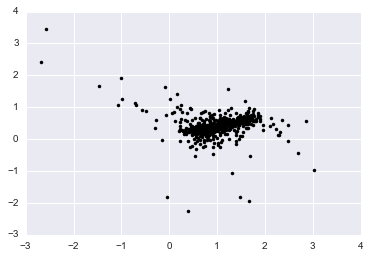

In [9]:
plt.figure('g-r vs r-i')

# data = SNIaCam[np.bitwise_and(
#         SNIaCam['g uncert'] < 0.01, SNIaCam['r uncert'] < 0.01, SNIaCam['i uncert'] < 0.01
#         )]
# plt.plot(data['g']-data['r'], data['r']-data['i'], 'k.')
plt.plot(SNIaCam['g']-SNIaCam['r'], SNIaCam['r']-SNIaCam['i'], 'k.')

This is mostly good. There are the few very bad colors that need to be corrected. Likey the errors of those outliers are bad.

## What are the values for a few SN looked at by Gupta 2011?

Lets look at the *ugriz* for SN1166, 1253 & 1371.

In [8]:
SNIaCam.columns
SNIaCam[np.logical_or(SNIaCam['CID']==1166, 
                      np.logical_or(SNIaCam['CID']==1253, SNIaCam['CID']==1371)
                     )][['CID', 'Z', 'MU', 'COLOR', 'X1', 'u', 'g', 'r', 'i', 'z']]

,CID,Z,MU,COLOR,X1,u,g,r,i,z
17,1166,0.382077,41.294899,0.001222,1.358340,25.311649,25.360130,25.333381,24.060039,23.495897
57,1371,0.119343,38.480900,-0.089316,0.818692,23.228621,21.517963,20.423611,19.999402,19.617180


SN1253 is not in the Campell data (or possibly the SMP, I doubt that), but it is in the Gupta analysis. Also the `color` and `x1` values do not match. Peter says that Gupta was using an early analysis and Campell is more complete so it does not matter too much if things changed. 

------

# FSPS

Charlie Conroy's Flexible Stellar Population Synthesis (FSPS), and dfm's python wrapper `python-fsps`, build simple stellar popuations (SSPs) and composite stellar populations (CSPs).

FSPS takes varring **IMFs** and **Metallicity** and produce simple stellar populations (SSPs) [note adjustments can be made via morphology of the horizontal branch, the blue straggler population, the post-AGB phase, and the location in the HR diagram of the TP-AGP phase.]. From these SSPs, we can get composite stellar populations (CSPs) for a variety of **star formation histories (SFHs)** and **dust attenuation**. This outputs **Spectra** and **magnitudes**.

[wrong idea:] So if I have a 5 parameter model (**IMFs**, **Metallicity**, **SFHs**, **dust attenuation**, and **redshift**) with a Gaussian prior of known redshift from spectra, we can get an output of the 5 `urigz` magnitudes. We can take our local environment SMP magnitudes and find the best fit model & uncertainty. This can be by doing some 1000 trials/fits or something (MCMC?). Our MCMC code could randomly walk the 5D space of the Chi-square of the model & data. Then for each SN we have our 5 (really 4 because we already new **z**) model parameters and some sort of certainty quantity.

[aside:] Gupta 2011 used 4 parameters metallicity log[Z/Z_solar], dust attenuating old stellar light, the e-folding timescale of star formation, the time when star formation begins. Table 1 explains range of parameters.

I need **age** somewhere. I want to compare HR to local stellar population age, metallicity and possibly SFH. I will use equation 3 of Gupta 2011. This function is calculated below.

## Parameters - changing

Some parameters will be **varried to build the modle space** and others will be *determined by the indvidual SN or a outcome of the model*. Aka, **bold** variables indicate size of model space and *italicized* variables will change with each SN/model but implicetly.

* *redshift*
    * fixed per SN by data
* *number of stars*
    * from the scalling factor in the minimization process
* *stellar age*
    * from `.get_mags()` with using default `tage` parameter. Resulting ages can be found with method `.log_age`. Alterniatively, look at `.log_lbol` and `.stellar_mass` and how these change with the flag `compute_light_ages`.
* SFH
    * Peter says the the we will mostly be able to see something like the ratio of new stars vs medium/old stars. Since most things older then a several Gyrs will all look very similar. This means we need to make sure our models are most unique at late time. We can either have a varring percentage of contant sfh but keep tau constant or we can do what Gupta and others do and have no constant sfh but allow for large tau's to get a similar effect.
    * uses six parameters: `tau`, `const`, `sf_start`, `sf_trunc`, `tburst`, and `fburst`
    * **`tau`** ($\tau_{\text{SF}}$)
        * Gupta used `[0.1, 0.5, 1, 2, 3, 4, 6, 8, 10]`
        * possible range is $0.1 < \tau < 10^2$
    * **`const`**
        * default is `0` and should change
    * **`sf_start`** $t_{\text{start}}$
        * default is `0`. This may not need to change ever.
    * `sf_trunc`
        * default is that it does not truncate
    * **`tburst`**
        * defines age of the Universe when the burst occurs.
        * defaults to 11.0
        * If `tburst` > `tage` then there is no burst.
            * we are using a wide ragne of `tage`
    * **`fburst`**
        * defines the fraction of mass formed in an instantaneous burst of star formation
        * defaults to 0.0
* **metallicity**
    * `zcontinuous`
        * 0 - no interpolation
        * 1 - interperalted with `logzsol`
        * 2 - (distribution fuction) convolved with both `logzsol` & `pmetals`

## Parameters - check defualts
* IMF
* Dust atinuation
* Dust emmition
* metallicity handeling
* compute_light_ages -> do not change! I am not sure what it does, but it does bad things.


In [10]:
#Fast to set up model

# sdss_bands = fsps.find_filter('sdss')  #not in color order
sdss_bands = ['sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z'] 

# use default Kroupa IMF
# use default settings for delayed tau-model SFH,
#    should change these to build model space.
# redshift & metalicity
#    Needs to be implemented
# Stellar Population
#    Need to turn a lot of things on from cloudy
# Dust
#    Use Milky Way extinction law - cant change A_v like Peter wants
#    Use default. Different optical depth for old and new stars. (like Charlot et al 2000)
#    using default `dust_tesc` of 7.0 Gyr

#need to add: add_igm_absorption, and add_neb_emission. 
sp = fsps.StellarPopulation(zcontinuous=2, cloudy_dust=True, 
                            sfh=4)

In [11]:
modelParameterSpace = {
    'logzsol': np.array([-0.88, -0.59, -0.39, -0.2, 0, 0.20]),
    'tau': np.array([0.1, 0.5, 1, 2, 3, 4, 6, 8, 10]),
    'sf_start': np.array([0, 1, 2, 3, 4, 5, 6, 7]),
    'dust2': np.array([0, 0.1, 0.3, 0.5, 1.0, 1.5])
}

In [12]:
def defineModelSpace(z):
    '''
    This builds the model space for a given redshift. The models need to know the redshfit of 
    the object to correctly callcualte the apprent magnitude as it changes over distance and 
    K-corrections
    
    # Parameters
    z : float
        The observed redshift of the objects
        
    # Returns
    modelSpace : ?
        The *ugriz* output of each model. Stored in a multi-demenial array. The 
        dimensions are for the changes in parameters `['logzsol', 'tau', 'sf_star', 'tburst',
        'fburst']` followed by time and finally the *ugriz* values. 
    '''
    #indexes are . . . , age (currently 107), fitlers
    modelSpace = np.zeros((6, 9, 8, 6, 5))
    
    #iterate over metalicity
    for i, met in enumerate([-0.88, -0.59, -0.39, -0.2, 0, 0.20]):
        #only gives 99 for a value of -1
        sp.params['logzsol'] = met
        
        #iterate over `tau`
        #e-folding time of of sfh in Gyr
        for j, tau in enumerate([0.1, 0.5, 1, 2, 3, 4, 6, 8, 10]):
            sp.params['tau'] = tau
            
            #iterate over `sf_start`
            #burst start time in Gyr
            for k, sf_start in enumerate([0, 1, 2, 3, 4, 5, 6, 7]):
                sp.params['sf_start'] = sf_start
                
                #iterate over dust
                for l, dust2 in enumerate([0, 0.1, 0.3, 0.5, 1.0, 1.5]):
                    #using default `dust_tesc` of 7.0 Gyr
                    #optical depth of young stars is 3x that of old.
                    #Conroy 2009 says Charlot 2000 recomends (dust1, dust2) = (1.0, 0.3)
                    dust1 = 3.0*dust2
                    sp.params['dust1'] = dust1
                    sp.params['dust2'] = dust2
    
                    #remove `tage` for real data?
                    tage = cosmo.age(z).to('Gyr').value
                    modelSpace[i,j,k,l] = sp.get_mags(tage=tage, redshift=z, bands=sdss_bands)
    
    return modelSpace

In [13]:
def saveModelSpace(data, fileName=None, header=None):
    """
    Save model space data at `resources/fspsModelSpace.csv`
    
    # Parameters
    
    data : multidimentional numpy array
        The *ugriz* outputs of the poly dimentional model space.
        
    fileName : string
        The name/location of where the file should be stored. Defaults to 
        `'resources/fspsModelSpace.csv'`
        
    header : string
        The first line of the file to be saved. Defaults to 
        `"Flattened *ugriz* output on {} from model space generated from FSPS with 
        dimmetions `['logzsol', 'tau', 'sf_star', 'tburst', 'fburst']` and shape 
        {}".format(date, shape)`
    """
    
    #get curent date-time as string
    date = datetime.now().strftime('%Y-%m-%d')
    
    #set fileName
    if fileName is None:
        fileName='resources/fspsModelSpace.csv'
    
    #create header information
    if header is None:
        shape = data.shape
        header = "Flattened *ugriz* output on {} from model space generated from FSPS with dimmetions `['logzsol', 'tau', 'sf_star', 'dust2']` and shape {}".format(date, shape)
    
    #save data
    np.savetxt(fileName, data.flatten(), delimiter=',', header=header)
    print('{} saved'.format(fileName))

def readModelSpace(fileName='resources/fspsModelSpace.csv'):
    """
    reads saved, via `saveModelSapce()`, model space and reshapes it.
    
    # Parameters
    
    fileName : str
        
    # Returns
    
    modelSpace : multidimentional numpy array
        The *ugriz* outputs of the poly dimentional model space.
    """
    #get data
    data = np.loadtxt(fileName, delimiter=',')
    
    #get final shape
    with open(fileName, 'r') as f:
        firstLine = f.readline()
    
    shapeString = re.search(r'\d,.*\d', firstLine).group(0)
    shape = np.fromstring(shapeString, dtype=int, sep=',')
    
    #create modelSpace object
    modelSpace = data.reshape(shape)
    return modelSpace

Lets build & save all of the needed models

In [25]:
#note: takes 20hrs on my macbook with nothing else happening
length = len(SNIaCam.dropna()['Z'].values)
for i, redshift in enumerate(SNIaCam.dropna()['Z'].values):
    print('running {} of {}: z = {}'.format(i, length, redshift))
    a = defineModelSpace(redshift)
    fileName = 'resources/fspsModelSpace/fspsModelSpace_{}.csv'.format(redshift)
    saveModelSpace(a, fileName)

running 0 of 607: z = 0.06539160013198853
resources/fspsModelSpace/fspsModelSpace_0.06539160013198853.csv saved
running 1 of 607: z = 0.25381600856781006
resources/fspsModelSpace/fspsModelSpace_0.25381600856781006.csv saved
running 2 of 607: z = 0.1297551989555359
resources/fspsModelSpace/fspsModelSpace_0.1297551989555359.csv saved
running 3 of 607: z = 0.2517249882221222
resources/fspsModelSpace/fspsModelSpace_0.2517249882221222.csv saved
running 4 of 607: z = 0.10416100174188614
resources/fspsModelSpace/fspsModelSpace_0.10416100174188614.csv saved
running 5 of 607: z = 0.3008129894733429
resources/fspsModelSpace/fspsModelSpace_0.3008129894733429.csv saved
running 6 of 607: z = 0.28109198808670044
resources/fspsModelSpace/fspsModelSpace_0.28109198808670044.csv saved
running 7 of 607: z = 0.04524829983711243
resources/fspsModelSpace/fspsModelSpace_0.04524829983711243.csv saved
running 8 of 607: z = 0.25760799646377563
resources/fspsModelSpace/fspsModelSpace_0.25760799646377563.csv save

------

# Finding Correct Model

Going to stick with a model space per redshift and keep things discrete. Even though each space has 2592 models in it. Next we can minimize over continuous varriables, maybe with a better initial guess/ smaller space.

We will 
1. first calculate the $\chi^2$ for each model. 
2. Then calculate Probability Desnity Functions (PDFs) as $e^{\chi^2/2}$. 
3. From here we can get "confidance" intervals.

First lets calculate the $\chi^2$s.

In [14]:
def chisquare(c, model, dataDF):
    """
    A chi-square function to minimize the scalling factor that brings up the FSPS model to
    the observed *ugriz* values. This scaleing factor will be used to calculate the mass of 
    the stellar population. The model and the data should be fixed values.
    
    # Parameters
    
    c : float
    
    model : array
        This is the output of the FSPS models. Needs to be in the order `['u', 'g', 'r', 'i', 'z']`. 
        
    dataDF : DataFrame
        This is the observed data. Needs to contain `['u', 'g', 'r', 'i', 'z', 'u uncert',
        'g uncert', 'r uncert', 'i uncert', 'z uncert']`
        
    # Returns
    
    chi_square : float
        The chi-square for the given data, model and scalling parameter. 
    """
    data = dataDF[['u', 'g', 'r', 'i', 'z']].values
    uncert = dataDF[['u uncert', 'g uncert', 'r uncert', 'i uncert', 'z uncert']].values
    
    return np.sum((model+c-data)**2/uncert**2)

This next section calculated the $\chi^2$ and then saves them to disk.

In [185]:
#runs for ~20 hours
#get model space names
files = glob('resources/fspsModelSpace/*')
#SN4019, SN6057, SN14279 -- built system with these three
# files = ['resources/fspsModelSpace/fspsModelSpace_0.1814039945602417.csv', 
#          'resources/fspsModelSpace/fspsModelSpace_0.06707180291414261.csv', 
#          'resources/fspsModelSpace/fspsModelSpace_0.04538949951529503.csv'] 
        #saving to disk rounded the last digit of number 2 & 3 in this list.
#was missing *u* band data
# files =['resources/fspsModelSpace/fspsModelSpace_0.09887129813432693.csv']
#165th was missing uncertainties
# files = files[165:]
    
#Add space in SNIaCam for fsps best-fit chi^2, fsps best-fit stellar mass constant
SNIaCam['fsps chi2'] = np.nan
SNIaCam['fsps const'] = np.nan


# files = [files[0]]
for f in files:
    print('Calculating Chi^2 for '+f[25:])
    #save redshift, needs to be at least 6 sig figs for `SNIaCam` to reconize it.
    redshift = float(f[40:-4])

    #read in model space
    a = readModelSpace(f)
    modelShape = a.shape[0:-1]
    
    #set up data
    data = SNIaCam[SNIaCam['Z']==redshift]
    data = data[['u', 'u uncert', 'g', 'g uncert', 'r', 'r uncert', 'i', 'i uncert', 'z', 'z uncert']]
    #if any are null, then send warning and dont computer best fit
    #todo(should have not computed model, or computed a model that is not *ugriz*)
    if data.isnull().values.any():
        warnings.warn(r'{} is missing a data value: {}'.format(f, data))
        continue
    #if uncertanty is zero, skip
    if np.any(data[['u uncert', 'g uncert', 'r uncert', 'i uncert', 'z uncert']] == 0):
        warnings.warn(r'{} has uncertainties set to zero: {}'.format(f, data))
        continue
    
    #make objects to store chi^2 & c
    chiMatrix = np.zeros(modelShape)
    cMatrix = np.zeros(modelShape)
    
    #iterate through model space
    # for metalicity
    for i in np.arange(modelShape[0]):
        
        # for `tau`
        for j in np.arange(modelShape[1]):
            
            # for `sf_start`
            for k in np.arange(modelShape[2]):
            
                # for dust
                for l in np.arange(modelShape[3]):
                    #find Chi-square and constant
                    #set up parameters
                    c = 10
                    model = a[i, j, k, l]
                    
                    #minimize
                    res = minimize(chisquare, c, args=(model, data), method='Nelder-Mead')

                    #save calculation
                    chiMatrix[i, j, k, l] = res.fun
                    cMatrix[i, j, k, l] = res.x[0]


    #save data
    #save chi^2 to disk
    header = "Flattened chi^2 for model space generated from FSPS with dimmetions `['logzsol', 'tau', 'sf_star', 'tburst', 'fburst']` and shape {}".format(modelShape)
    fileName = 'resources/fspsModelChi2/fspsModelChi2_{}.csv'.format(redshift)
    saveModelSpace(chiMatrix, fileName=fileName, header=header)
    
    #save fsps constant to disk
    header = "Flattened stellar population size constant (c) for model space generated from FSPS with dimmetions `['logzsol', 'tau', 'sf_star', 'tburst', 'fburst']` and shape {}".format(modelShape)
    fileName = 'resources/fspsModelC/fspsModelC_{}.csv'.format(redshift)
    saveModelSpace(cMatrix, fileName=fileName, header=header)
    
    #save chi^2 and constant to SN DataFrame
    #get index to use with `.loc`
    index = SNIaCam[SNIaCam['Z']==redshift].index.tolist()[0]
    bestFitIndex = np.array(np.where(chiMatrix == chiMatrix.min())).reshape(4)
    bestFitIndex=bestFitIndex.reshape(4)
    SNIaCam.loc[index, ['fsps chi2', 'fsps const']] = chiMatrix.min(), cMatrix[bestFitIndex[0], bestFitIndex[1], bestFitIndex[2], bestFitIndex[3]]
    
    print('Finished calucation & saved two files to disk. Minimum Chi^2 = '+str(chiMatrix.min()))

Calculating Chi^2 for fspsModelSpace_0.2193647027015686.csv
Calculating Chi^2 for fspsModelSpace_0.21993499994277954.csv


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.2193647027015686.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
252  24.698321       0.0  25.648577       0.0  24.396899       0.0  24.393815   

     i uncert          z  z uncert  
252       0.0  23.137225       0.0  


resources/fspsModelChi2/fspsModelChi2_0.21993499994277954.csv saved
resources/fspsModelC/fspsModelC_0.21993499994277954.csv saved
[0 3 1 4]
Finished calucation & saved two files to disk. Minimum Chi^2 = 2.96664365995
Calculating Chi^2 for fspsModelSpace_0.2202720046043396.csv
resources/fspsModelChi2/fspsModelChi2_0.2202720046043396.csv saved
resources/fspsModelC/fspsModelC_0.2202720046043396.csv saved
[5 3 2 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 16.564111047
Calculating Chi^2 for fspsModelSpace_0.22028200328350067.csv
resources/fspsModelChi2/fspsModelChi2_0.22028200328350067.csv saved
resources/fspsModelC/fspsModelC_0.22028200328350067.csv saved
[5 5 7 2]
Finished calucation & saved two files to disk. Minimum Chi^2 = 2.62542248319
Calculating Chi^2 for fspsModelSpace_0.220428004860878.csv
resources/fspsModelChi2/fspsModelChi2_0.220428004860878.csv saved
resources/fspsModelC/fspsModelC_0.220428004860878.csv saved
[0 7 7 5]
Finished calucation & saved two file

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.2274159938097.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
686  23.215249       0.0  21.383901       0.0  19.995226       0.0  19.492619   

     i uncert          z  z uncert  
686       0.0  19.129255       0.0  


resources/fspsModelChi2/fspsModelChi2_0.22842900454998016.csv saved
resources/fspsModelC/fspsModelC_0.22842900454998016.csv saved
[5 4 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 14.5404805587
Calculating Chi^2 for fspsModelSpace_0.22958700358867645.csv
resources/fspsModelChi2/fspsModelChi2_0.22958700358867645.csv saved
resources/fspsModelC/fspsModelC_0.22958700358867645.csv saved
[0 8 4 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 2.60610690064
Calculating Chi^2 for fspsModelSpace_0.23113800585269928.csv
resources/fspsModelChi2/fspsModelChi2_0.23113800585269928.csv saved
resources/fspsModelC/fspsModelC_0.23113800585269928.csv saved
[0 8 7 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 2.16058180438
Calculating Chi^2 for fspsModelSpace_0.23388899862766266.csv
Calculating Chi^2 for fspsModelSpace_0.2343509942293167.csv


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.23388899862766266.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
322  23.809492       0.0  22.366254       0.0  21.004159       0.0  20.534183   

     i uncert          z  z uncert  
322       0.0  20.113696       0.0  


resources/fspsModelChi2/fspsModelChi2_0.2343509942293167.csv saved
resources/fspsModelC/fspsModelC_0.2343509942293167.csv saved
[0 6 7 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 16.556914586
Calculating Chi^2 for fspsModelSpace_0.23454900085926056.csv
resources/fspsModelChi2/fspsModelChi2_0.23454900085926056.csv saved
resources/fspsModelC/fspsModelC_0.23454900085926056.csv saved
[4 6 0 4]
Finished calucation & saved two files to disk. Minimum Chi^2 = 2.0370391589
Calculating Chi^2 for fspsModelSpace_0.23613299429416656.csv
resources/fspsModelChi2/fspsModelChi2_0.23613299429416656.csv saved
resources/fspsModelC/fspsModelC_0.23613299429416656.csv saved
[0 3 2 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 1.80579742548
Calculating Chi^2 for fspsModelSpace_0.23626099526882172.csv
resources/fspsModelChi2/fspsModelChi2_0.23626099526882172.csv saved
resources/fspsModelC/fspsModelC_0.23626099526882172.csv saved
[2 3 2 4]
Finished calucation & saved tw

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.25222599506378174.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
139  22.782558       0.0  23.454782       0.0  22.654634       0.0  22.224683   

     i uncert         z  z uncert  
139       0.0  22.15983       0.0  


resources/fspsModelChi2/fspsModelChi2_0.25251200795173645.csv saved
resources/fspsModelC/fspsModelC_0.25251200795173645.csv saved
[2 8 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 11.3348280385
Calculating Chi^2 for fspsModelSpace_0.25328201055526733.csv
resources/fspsModelChi2/fspsModelChi2_0.25328201055526733.csv saved
resources/fspsModelC/fspsModelC_0.25328201055526733.csv saved
[1 0 3 4]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.196298486549
Calculating Chi^2 for fspsModelSpace_0.2532910108566284.csv
resources/fspsModelChi2/fspsModelChi2_0.2532910108566284.csv saved
resources/fspsModelC/fspsModelC_0.2532910108566284.csv saved
[3 6 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 10.781795816
Calculating Chi^2 for fspsModelSpace_0.2536439895629883.csv
resources/fspsModelChi2/fspsModelChi2_0.2536439895629883.csv saved
resources/fspsModelC/fspsModelC_0.2536439895629883.csv saved
[1 4 0 5]
Finished calucation & saved two 

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.2574650049209595.csv has uncertainties set to zero:             u  u uncert          g  g uncert          r  r uncert          i  \
18  23.952219       0.0  23.821544       0.0  22.788783       0.0  22.369431   

    i uncert          z  z uncert  
18       0.0  22.023024       0.0  


resources/fspsModelChi2/fspsModelChi2_0.25760799646377563.csv saved
resources/fspsModelC/fspsModelC_0.25760799646377563.csv saved
[0 8 3 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 2.43687205057
Calculating Chi^2 for fspsModelSpace_0.2582339942455292.csv
resources/fspsModelChi2/fspsModelChi2_0.2582339942455292.csv saved
resources/fspsModelC/fspsModelC_0.2582339942455292.csv saved
[5 6 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 2.72853610725
Calculating Chi^2 for fspsModelSpace_0.25866299867630005.csv
resources/fspsModelChi2/fspsModelChi2_0.25866299867630005.csv saved
resources/fspsModelC/fspsModelC_0.25866299867630005.csv saved
[5 2 3 1]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.910501471989
Calculating Chi^2 for fspsModelSpace_0.2588469982147217.csv
resources/fspsModelChi2/fspsModelChi2_0.2588469982147217.csv saved
resources/fspsModelC/fspsModelC_0.2588469982147217.csv saved
[4 3 2 5]
Finished calucation & saved two

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:35: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.25904300808906555.csv is missing a data value:        u  u uncert          g  g uncert          r  r uncert          i  \
409  inf       NaN  23.677954  0.058375  23.118036  0.041601  22.917884   

     i uncert          z  z uncert  
409  0.047235  22.653256  0.173897  


Calculating Chi^2 for fspsModelSpace_0.2590819001197815.csv
resources/fspsModelChi2/fspsModelChi2_0.2590819001197815.csv saved
resources/fspsModelC/fspsModelC_0.2590819001197815.csv saved
[5 4 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 6.58371440848
Calculating Chi^2 for fspsModelSpace_0.2599700093269348.csv
resources/fspsModelChi2/fspsModelChi2_0.2599700093269348.csv saved
resources/fspsModelC/fspsModelC_0.2599700093269348.csv saved
[5 2 7 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 2.24304037594
Calculating Chi^2 for fspsModelSpace_0.2619200050830841.csv
resources/fspsModelChi2/fspsModelChi2_0.2619200050830841.csv saved
resources/fspsModelC/fspsModelC_0.2619200050830841.csv saved
[1 8 6 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 4.80203365393
Calculating Chi^2 for fspsModelSpace_0.262253999710083.csv
resources/fspsModelChi2/fspsModelChi2_0.262253999710083.csv saved
resources/fspsModelC/fspsModelC_0.262253999710083.

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:35: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.2693290114402771.csv is missing a data value:       u  u uncert          g  g uncert          r  r uncert          i  \
46  inf       NaN  22.328838  0.023015  21.361666  0.012031  20.956946   

    i uncert          z  z uncert  
46  0.010518  20.627055  0.027415  


resources/fspsModelChi2/fspsModelChi2_0.27000701427459717.csv saved
resources/fspsModelC/fspsModelC_0.27000701427459717.csv saved
[5 4 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.545147666077
Calculating Chi^2 for fspsModelSpace_0.27094998955726624.csv
resources/fspsModelChi2/fspsModelChi2_0.27094998955726624.csv saved
resources/fspsModelC/fspsModelC_0.27094998955726624.csv saved
[0 8 4 4]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.442110561139
Calculating Chi^2 for fspsModelSpace_0.270999014377594.csv
resources/fspsModelChi2/fspsModelChi2_0.270999014377594.csv saved
resources/fspsModelC/fspsModelC_0.270999014377594.csv saved
[0 5 1 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 20.2808856539
Calculating Chi^2 for fspsModelSpace_0.27135398983955383.csv
resources/fspsModelChi2/fspsModelChi2_0.27135398983955383.csv saved
resources/fspsModelC/fspsModelC_0.27135398983955383.csv saved
[4 5 0 5]
Finished calucation & saved tw

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.27730101346969604.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
464  24.715441       0.0  23.996513       0.0  22.909131       0.0  22.489288   

     i uncert          z  z uncert  
464       0.0  22.226076       0.0  


Calculating Chi^2 for fspsModelSpace_0.2774411141872406.csv
resources/fspsModelChi2/fspsModelChi2_0.2774411141872406.csv saved
resources/fspsModelC/fspsModelC_0.2774411141872406.csv saved
[3 3 1 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.162561406055
Calculating Chi^2 for fspsModelSpace_0.2775680124759674.csv
resources/fspsModelChi2/fspsModelChi2_0.2775680124759674.csv saved
resources/fspsModelC/fspsModelC_0.2775680124759674.csv saved
[1 7 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 6.2682514175
Calculating Chi^2 for fspsModelSpace_0.2777009904384613.csv
resources/fspsModelChi2/fspsModelChi2_0.2777009904384613.csv saved
resources/fspsModelC/fspsModelC_0.2777009904384613.csv saved
[5 4 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.780470985692
Calculating Chi^2 for fspsModelSpace_0.27775099873542786.csv
resources/fspsModelChi2/fspsModelChi2_0.27775099873542786.csv saved
resources/fspsModelC/fspsModelC_0.27775099873

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.2808550000190735.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
478  22.738842       0.0  21.930706       0.0  21.068616       0.0  20.712363   

     i uncert          z  z uncert  
478       0.0  20.277914       0.0  


resources/fspsModelChi2/fspsModelChi2_0.28099900484085083.csv saved
resources/fspsModelC/fspsModelC_0.28099900484085083.csv saved
[5 5 1 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 4.30831951136
Calculating Chi^2 for fspsModelSpace_0.28109198808670044.csv
resources/fspsModelChi2/fspsModelChi2_0.28109198808670044.csv saved
resources/fspsModelC/fspsModelC_0.28109198808670044.csv saved
[0 4 3 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.0451010810879
Calculating Chi^2 for fspsModelSpace_0.28111299872398376.csv
Calculating Chi^2 for fspsModelSpace_0.281345009803772.csv


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.28111299872398376.csv has uncertainties set to zero:              u  u uncert          g  g uncert         r  r uncert          i  \
206  26.329655       0.0  25.813772       0.0  24.89383       0.0  25.130763   

     i uncert          z  z uncert  
206       0.0  23.686839       0.0  


resources/fspsModelChi2/fspsModelChi2_0.281345009803772.csv saved
resources/fspsModelC/fspsModelC_0.281345009803772.csv saved
[4 3 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 4.64238865555
Calculating Chi^2 for fspsModelSpace_0.2819879949092865.csv
resources/fspsModelChi2/fspsModelChi2_0.2819879949092865.csv saved
resources/fspsModelC/fspsModelC_0.2819879949092865.csv saved
[5 8 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 5.18098035297
Calculating Chi^2 for fspsModelSpace_0.28220000863075256.csv
Calculating Chi^2 for fspsModelSpace_0.2823919951915741.csv


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.28220000863075256.csv has uncertainties set to zero:             u  u uncert          g  g uncert          r  r uncert          i  \
609  25.69351       0.0  24.330189       0.0  23.174979       0.0  22.714161   

     i uncert          z  z uncert  
609       0.0  22.203087       0.0  


resources/fspsModelChi2/fspsModelChi2_0.2823919951915741.csv saved
resources/fspsModelC/fspsModelC_0.2823919951915741.csv saved
[0 7 5 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 5.635330856
Calculating Chi^2 for fspsModelSpace_0.2827869951725006.csv
resources/fspsModelChi2/fspsModelChi2_0.2827869951725006.csv saved
resources/fspsModelC/fspsModelC_0.2827869951725006.csv saved
[3 4 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 9.7990720911
Calculating Chi^2 for fspsModelSpace_0.2839609980583191.csv
resources/fspsModelChi2/fspsModelChi2_0.2839609980583191.csv saved
resources/fspsModelC/fspsModelC_0.2839609980583191.csv saved
[0 6 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 10.231676781
Calculating Chi^2 for fspsModelSpace_0.2846199870109558.csv


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:35: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.2846199870109558.csv is missing a data value:        u  u uncert          g  g uncert          r  r uncert        i  \
339  inf       NaN  24.685935  0.257272  23.667387   0.11129  23.3676   

     i uncert          z  z uncert  
339   0.08517  22.820049  0.249149  


Calculating Chi^2 for fspsModelSpace_0.2858240008354187.csv
resources/fspsModelChi2/fspsModelChi2_0.2858240008354187.csv saved
resources/fspsModelC/fspsModelC_0.2858240008354187.csv saved
[5 4 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 1.55847244415
Calculating Chi^2 for fspsModelSpace_0.285847008228302.csv
resources/fspsModelChi2/fspsModelChi2_0.285847008228302.csv saved
resources/fspsModelC/fspsModelC_0.285847008228302.csv saved
[5 5 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 10.2751080062
Calculating Chi^2 for fspsModelSpace_0.2867029905319214.csv
resources/fspsModelChi2/fspsModelChi2_0.2867029905319214.csv saved
resources/fspsModelC/fspsModelC_0.2867029905319214.csv saved
[0 3 1 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 1.15604991313
Calculating Chi^2 for fspsModelSpace_0.28689301013946533.csv
resources/fspsModelChi2/fspsModelChi2_0.28689301013946533.csv saved
resources/fspsModelC/fspsModelC_0.286893010139465

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.29067501425743103.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
595  25.018395       0.0  22.697893       0.0  21.439986       0.0  20.942603   

     i uncert          z  z uncert  
595       0.0  20.475172       0.0  


resources/fspsModelChi2/fspsModelChi2_0.29107698798179626.csv saved
resources/fspsModelC/fspsModelC_0.29107698798179626.csv saved
[3 3 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 5.87863913601
Calculating Chi^2 for fspsModelSpace_0.29134899377822876.csv
resources/fspsModelChi2/fspsModelChi2_0.29134899377822876.csv saved
resources/fspsModelC/fspsModelC_0.29134899377822876.csv saved
[5 2 6 1]
Finished calucation & saved two files to disk. Minimum Chi^2 = 3.17396003564
Calculating Chi^2 for fspsModelSpace_0.2918330132961273.csv
resources/fspsModelChi2/fspsModelChi2_0.2918330132961273.csv saved
resources/fspsModelC/fspsModelC_0.2918330132961273.csv saved
[4 3 1 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 9.36371300102
Calculating Chi^2 for fspsModelSpace_0.29219698905944824.csv
resources/fspsModelChi2/fspsModelChi2_0.29219698905944824.csv saved
resources/fspsModelC/fspsModelC_0.29219698905944824.csv saved
[5 5 0 5]
Finished calucation & saved t

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:35: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.2956390082836151.csv is missing a data value:        u  u uncert          g  g uncert          r  r uncert          i  \
537  inf       NaN  26.989999  1.521489  25.097547  0.289377  24.543253   

     i uncert          z  z uncert  
537  0.239922  23.924885  0.537536  


resources/fspsModelChi2/fspsModelChi2_0.29628899693489075.csv saved
resources/fspsModelC/fspsModelC_0.29628899693489075.csv saved
[0 8 4 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 3.13448588904
Calculating Chi^2 for fspsModelSpace_0.29683399200439453.csv
resources/fspsModelChi2/fspsModelChi2_0.29683399200439453.csv saved
resources/fspsModelC/fspsModelC_0.29683399200439453.csv saved
[5 4 1 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 2.10613266185
Calculating Chi^2 for fspsModelSpace_0.2978050112724304.csv
resources/fspsModelChi2/fspsModelChi2_0.2978050112724304.csv saved
resources/fspsModelC/fspsModelC_0.2978050112724304.csv saved
[5 8 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 4.00109220005
Calculating Chi^2 for fspsModelSpace_0.2980419993400574.csv
resources/fspsModelChi2/fspsModelChi2_0.2980419993400574.csv saved
resources/fspsModelC/fspsModelC_0.2980419993400574.csv saved
[4 2 6 0]
Finished calucation & saved two 

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:35: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.306192010641098.csv is missing a data value:        u  u uncert          g  g uncert          r  r uncert          i  \
372  inf       NaN  22.875655  0.034081  21.380696  0.011156  20.784435   

     i uncert         z  z uncert  
372  0.009866  20.52979  0.030341  


resources/fspsModelChi2/fspsModelChi2_0.30636999011039734.csv saved
resources/fspsModelC/fspsModelC_0.30636999011039734.csv saved
[2 5 1 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 18.6612839524
Calculating Chi^2 for fspsModelSpace_0.3065760135650635.csv
Calculating Chi^2 for fspsModelSpace_0.3067770004272461.csv


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.3065760135650635.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
508  25.998144       0.0  22.336527       0.0  20.763091       0.0  20.252339   

     i uncert          z  z uncert  
508       0.0  19.909398       0.0  


resources/fspsModelChi2/fspsModelChi2_0.3067770004272461.csv saved
resources/fspsModelC/fspsModelC_0.3067770004272461.csv saved
[0 7 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 2.91170657138
Calculating Chi^2 for fspsModelSpace_0.3072054088115692.csv
resources/fspsModelChi2/fspsModelChi2_0.3072054088115692.csv saved
resources/fspsModelC/fspsModelC_0.3072054088115692.csv saved
[2 0 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 10.038710207
Calculating Chi^2 for fspsModelSpace_0.3077855110168457.csv
resources/fspsModelChi2/fspsModelChi2_0.3077855110168457.csv saved
resources/fspsModelC/fspsModelC_0.3077855110168457.csv saved
[4 1 7 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 9.46217993358
Calculating Chi^2 for fspsModelSpace_0.30800798535346985.csv
resources/fspsModelChi2/fspsModelChi2_0.30800798535346985.csv saved
resources/fspsModelC/fspsModelC_0.30800798535346985.csv saved
[0 5 0 0]
Finished calucation & saved two fil

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.3095340132713318.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
233  24.041329       0.0  23.058916       0.0  21.751019       0.0  21.190414   

     i uncert          z  z uncert  
233       0.0  20.746908       0.0  


resources/fspsModelChi2/fspsModelChi2_0.30963200330734253.csv saved
resources/fspsModelC/fspsModelC_0.30963200330734253.csv saved
[5 3 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.808069143615
Calculating Chi^2 for fspsModelSpace_0.3098379969596863.csv
resources/fspsModelChi2/fspsModelChi2_0.3098379969596863.csv saved
resources/fspsModelC/fspsModelC_0.3098379969596863.csv saved
[5 4 1 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 6.98878307202
Calculating Chi^2 for fspsModelSpace_0.3100619912147522.csv
resources/fspsModelChi2/fspsModelChi2_0.3100619912147522.csv saved
resources/fspsModelC/fspsModelC_0.3100619912147522.csv saved
[3 6 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 11.9533878162
Calculating Chi^2 for fspsModelSpace_0.3104040026664734.csv
resources/fspsModelChi2/fspsModelChi2_0.3104040026664734.csv saved
resources/fspsModelC/fspsModelC_0.3104040026664734.csv saved
[5 3 0 0]
Finished calucation & saved two fi

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.31314900517463684.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
160  23.806499       0.0  22.017258       0.0  20.521541       0.0  19.940935   

     i uncert          z  z uncert  
160       0.0  19.564667       0.0  


resources/fspsModelChi2/fspsModelChi2_0.3131529986858368.csv saved
resources/fspsModelC/fspsModelC_0.3131529986858368.csv saved
[5 4 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 11.3912873725
Calculating Chi^2 for fspsModelSpace_0.31343400478363037.csv
resources/fspsModelChi2/fspsModelChi2_0.31343400478363037.csv saved
resources/fspsModelC/fspsModelC_0.31343400478363037.csv saved
[1 6 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 7.04976030523
Calculating Chi^2 for fspsModelSpace_0.31356269121170044.csv
resources/fspsModelChi2/fspsModelChi2_0.31356269121170044.csv saved
resources/fspsModelC/fspsModelC_0.31356269121170044.csv saved
[5 3 2 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 92.6638560533
Calculating Chi^2 for fspsModelSpace_0.3144190013408661.csv
resources/fspsModelChi2/fspsModelChi2_0.3144190013408661.csv saved
resources/fspsModelC/fspsModelC_0.3144190013408661.csv saved
[5 2 3 1]
Finished calucation & saved two

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.3295559883117676.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
253  24.585491       0.0  22.858464       0.0  21.270256       0.0  20.764904   

     i uncert         z  z uncert  
253       0.0  20.45908       0.0  
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.3304629921913147.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
547  24.315764       0.0  23.718522       0.0  22.407749       0.0  21.897243   

     i uncert         z  z uncert  
547       0.0  21.42633       0.0  


Calculating Chi^2 for fspsModelSpace_0.3307960033416748.csv
resources/fspsModelChi2/fspsModelChi2_0.3307960033416748.csv saved
resources/fspsModelC/fspsModelC_0.3307960033416748.csv saved
[2 1 7 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 3.43167724682
Calculating Chi^2 for fspsModelSpace_0.33091700077056885.csv
resources/fspsModelChi2/fspsModelChi2_0.33091700077056885.csv saved
resources/fspsModelC/fspsModelC_0.33091700077056885.csv saved
[5 4 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 12.2587864537
Calculating Chi^2 for fspsModelSpace_0.3309839963912964.csv
resources/fspsModelChi2/fspsModelChi2_0.3309839963912964.csv saved
resources/fspsModelC/fspsModelC_0.3309839963912964.csv saved
[1 0 5 4]
Finished calucation & saved two files to disk. Minimum Chi^2 = 4.05055297112
Calculating Chi^2 for fspsModelSpace_0.3315649926662445.csv
resources/fspsModelChi2/fspsModelChi2_0.3315649926662445.csv saved
resources/fspsModelC/fspsModelC_0.33156499266

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.3402799963951111.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
110  22.841132       0.0  22.401723       0.0  21.555143       0.0  21.280905   

     i uncert          z  z uncert  
110       0.0  20.976614       0.0  


resources/fspsModelChi2/fspsModelChi2_0.3402920067310333.csv saved
resources/fspsModelC/fspsModelC_0.3402920067310333.csv saved
[5 3 1 4]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.5184343033
Calculating Chi^2 for fspsModelSpace_0.34097999334335327.csv
resources/fspsModelChi2/fspsModelChi2_0.34097999334335327.csv saved
resources/fspsModelC/fspsModelC_0.34097999334335327.csv saved
[2 7 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 16.8704038314
Calculating Chi^2 for fspsModelSpace_0.341185986995697.csv
resources/fspsModelChi2/fspsModelChi2_0.341185986995697.csv saved
resources/fspsModelC/fspsModelC_0.341185986995697.csv saved
[0 3 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 3.44770399342
Calculating Chi^2 for fspsModelSpace_0.3412410020828247.csv
resources/fspsModelChi2/fspsModelChi2_0.3412410020828247.csv saved
resources/fspsModelC/fspsModelC_0.3412410020828247.csv saved
[5 3 1 5]
Finished calucation & saved two files 

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.34915998578071594.csv has uncertainties set to zero:              u  u uncert         g  g uncert          r  r uncert          i  \
607  24.271003       0.0  23.48399       0.0  22.198321       0.0  21.661233   

     i uncert         z  z uncert  
607       0.0  21.30153       0.0  


resources/fspsModelChi2/fspsModelChi2_0.3501960039138794.csv saved
resources/fspsModelC/fspsModelC_0.3501960039138794.csv saved
[5 3 1 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 9.11408038985
Calculating Chi^2 for fspsModelSpace_0.35022398829460144.csv
resources/fspsModelChi2/fspsModelChi2_0.35022398829460144.csv saved
resources/fspsModelC/fspsModelC_0.35022398829460144.csv saved
[5 4 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 4.23736187762
Calculating Chi^2 for fspsModelSpace_0.35026800632476807.csv
resources/fspsModelChi2/fspsModelChi2_0.35026800632476807.csv saved
resources/fspsModelC/fspsModelC_0.35026800632476807.csv saved
[5 3 1 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.758758305016
Calculating Chi^2 for fspsModelSpace_0.3515689969062805.csv
resources/fspsModelChi2/fspsModelChi2_0.3515689969062805.csv saved
resources/fspsModelC/fspsModelC_0.3515689969062805.csv saved
[2 0 0 4]
Finished calucation & saved tw

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.3596870005130768.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
528  23.827621       0.0  23.087817       0.0  21.557274       0.0  20.962011   

     i uncert          z  z uncert  
528       0.0  20.512875       0.0  


resources/fspsModelChi2/fspsModelChi2_0.3604069948196411.csv saved
resources/fspsModelC/fspsModelC_0.3604069948196411.csv saved
[0 8 7 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 4.70747539618
Calculating Chi^2 for fspsModelSpace_0.360617995262146.csv
resources/fspsModelChi2/fspsModelChi2_0.360617995262146.csv saved
resources/fspsModelC/fspsModelC_0.360617995262146.csv saved
[5 4 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 6.06064852286
Calculating Chi^2 for fspsModelSpace_0.36119601130485535.csv
resources/fspsModelChi2/fspsModelChi2_0.36119601130485535.csv saved
resources/fspsModelC/fspsModelC_0.36119601130485535.csv saved
[5 8 3 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 2.43260314917
Calculating Chi^2 for fspsModelSpace_0.3613089919090271.csv
resources/fspsModelChi2/fspsModelChi2_0.3613089919090271.csv saved
resources/fspsModelC/fspsModelC_0.3613089919090271.csv saved
[1 8 0 5]
Finished calucation & saved two files

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.36220699548721313.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
355  25.246319       0.0  24.218801       0.0  23.026386       0.0  22.701127   

     i uncert          z  z uncert  
355       0.0  22.249325       0.0  


resources/fspsModelChi2/fspsModelChi2_0.3623589873313904.csv saved
resources/fspsModelC/fspsModelC_0.3623589873313904.csv saved
[0 4 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 13.9795798268
Calculating Chi^2 for fspsModelSpace_0.36434099078178406.csv
resources/fspsModelChi2/fspsModelChi2_0.36434099078178406.csv saved
resources/fspsModelC/fspsModelC_0.36434099078178406.csv saved
[0 1 0 3]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.525011805736
Calculating Chi^2 for fspsModelSpace_0.3644550144672394.csv
Calculating Chi^2 for fspsModelSpace_0.3645530045032501.csv


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.3644550144672394.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert         i  \
240  24.671257       0.0  23.575036       0.0  22.287001       0.0  21.80436   

     i uncert          z  z uncert  
240       0.0  21.342964       0.0  


resources/fspsModelChi2/fspsModelChi2_0.3645530045032501.csv saved
resources/fspsModelC/fspsModelC_0.3645530045032501.csv saved
[4 3 0 1]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.563411665422
Calculating Chi^2 for fspsModelSpace_0.3649890124797821.csv
resources/fspsModelChi2/fspsModelChi2_0.3649890124797821.csv saved
resources/fspsModelC/fspsModelC_0.3649890124797821.csv saved
[2 6 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 16.9404523762
Calculating Chi^2 for fspsModelSpace_0.36546701192855835.csv
resources/fspsModelChi2/fspsModelChi2_0.36546701192855835.csv saved
resources/fspsModelC/fspsModelC_0.36546701192855835.csv saved
[4 3 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 21.2866769341
Calculating Chi^2 for fspsModelSpace_0.3671799898147583.csv
resources/fspsModelChi2/fspsModelChi2_0.3671799898147583.csv saved
resources/fspsModelC/fspsModelC_0.3671799898147583.csv saved
[5 6 0 0]
Finished calucation & saved two f

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.36743998527526855.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
398  24.536988       0.0  23.376278       0.0  21.714296       0.0  21.132889   

     i uncert          z  z uncert  
398       0.0  20.748099       0.0  


resources/fspsModelChi2/fspsModelChi2_0.3683759868144989.csv saved
resources/fspsModelC/fspsModelC_0.3683759868144989.csv saved
[4 2 3 4]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.170338782997
Calculating Chi^2 for fspsModelSpace_0.3684220016002655.csv
resources/fspsModelChi2/fspsModelChi2_0.3684220016002655.csv saved
resources/fspsModelC/fspsModelC_0.3684220016002655.csv saved
[5 4 6 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 1.83372898778
Calculating Chi^2 for fspsModelSpace_0.36904799938201904.csv
resources/fspsModelChi2/fspsModelChi2_0.36904799938201904.csv saved
resources/fspsModelC/fspsModelC_0.36904799938201904.csv saved
[0 8 7 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 11.0249878942
Calculating Chi^2 for fspsModelSpace_0.37050101161003113.csv
resources/fspsModelChi2/fspsModelChi2_0.37050101161003113.csv saved
resources/fspsModelC/fspsModelC_0.37050101161003113.csv saved
[3 3 0 5]
Finished calucation & saved tw

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.37571200728416443.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
491  24.148056       0.0  24.153527       0.0  22.528785       0.0  21.851041   

     i uncert          z  z uncert  
491       0.0  21.355396       0.0  


resources/fspsModelChi2/fspsModelChi2_0.3762420117855072.csv saved
resources/fspsModelC/fspsModelC_0.3762420117855072.csv saved
[2 4 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 5.30847767651
Calculating Chi^2 for fspsModelSpace_0.3766840100288391.csv
resources/fspsModelChi2/fspsModelChi2_0.3766840100288391.csv saved
resources/fspsModelC/fspsModelC_0.3766840100288391.csv saved
[0 5 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 5.14889153696
Calculating Chi^2 for fspsModelSpace_0.3770819902420044.csv
resources/fspsModelChi2/fspsModelChi2_0.3770819902420044.csv saved
resources/fspsModelC/fspsModelC_0.3770819902420044.csv saved
[0 3 1 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.951261780674
Calculating Chi^2 for fspsModelSpace_0.3773050010204315.csv
resources/fspsModelChi2/fspsModelChi2_0.3773050010204315.csv saved
resources/fspsModelC/fspsModelC_0.3773050010204315.csv saved
[2 3 0 5]
Finished calucation & saved two file

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.4293229877948761.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
216  28.748321       0.0  23.069475       0.0  21.554017       0.0  20.929151   

     i uncert          z  z uncert  
216       0.0  20.517681       0.0  
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.4299969971179962.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
423  26.055099       0.0  23.186172       0.0  21.574349       0.0  20.973678   

     i uncert          z  z uncert  
423       0.0  20.628655       0.0  


Calculating Chi^2 for fspsModelSpace_0.4312730133533478.csv
resources/fspsModelChi2/fspsModelChi2_0.4312730133533478.csv saved
resources/fspsModelC/fspsModelC_0.4312730133533478.csv saved
[5 3 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 1.67710985126
Calculating Chi^2 for fspsModelSpace_0.43296200037002563.csv
resources/fspsModelChi2/fspsModelChi2_0.43296200037002563.csv saved
resources/fspsModelC/fspsModelC_0.43296200037002563.csv saved
[2 8 6 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 3.42148280637
Calculating Chi^2 for fspsModelSpace_0.43303200602531433.csv
resources/fspsModelChi2/fspsModelChi2_0.43303200602531433.csv saved
resources/fspsModelC/fspsModelC_0.43303200602531433.csv saved
[5 8 1 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 7.05217321076
Calculating Chi^2 for fspsModelSpace_0.4358699917793274.csv
resources/fspsModelChi2/fspsModelChi2_0.4358699917793274.csv saved
resources/fspsModelC/fspsModelC_0.43586999

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.4447839856147766.csv has uncertainties set to zero:             u  u uncert          g  g uncert          r  r uncert          i  \
422  26.12023       0.0  23.336146       0.0  21.686945       0.0  21.063826   

     i uncert          z  z uncert  
422       0.0  20.677209       0.0  


resources/fspsModelChi2/fspsModelChi2_0.447845995426178.csv saved
resources/fspsModelC/fspsModelC_0.447845995426178.csv saved
[3 3 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.937871317189
Calculating Chi^2 for fspsModelSpace_0.44891801476478577.csv
resources/fspsModelChi2/fspsModelChi2_0.44891801476478577.csv saved
resources/fspsModelC/fspsModelC_0.44891801476478577.csv saved
[5 3 1 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 6.5141856794
Calculating Chi^2 for fspsModelSpace_0.4498080015182495.csv
Calculating Chi^2 for fspsModelSpace_0.4510209858417511.csv


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.4498080015182495.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
688  26.437735       0.0  23.888188       0.0  22.135406       0.0  21.334754   

     i uncert          z  z uncert  
688       0.0  20.854383       0.0  
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.4510209858417511.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
196  24.526111       0.0  23.983304       0.0  22.506598       0.0  21.759452   

     i uncert          z  z uncert  
196       0.0  21.242671       0.0  


Calculating Chi^2 for fspsModelSpace_0.4520510137081146.csv
resources/fspsModelChi2/fspsModelChi2_0.4520510137081146.csv saved
resources/fspsModelC/fspsModelC_0.4520510137081146.csv saved
[5 5 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 9.01368395362
Calculating Chi^2 for fspsModelSpace_0.45380398631095886.csv
resources/fspsModelChi2/fspsModelChi2_0.45380398631095886.csv saved
resources/fspsModelC/fspsModelC_0.45380398631095886.csv saved
[5 2 3 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 8.47751785713
Calculating Chi^2 for fspsModelSpace_0.4543290138244629.csv
resources/fspsModelChi2/fspsModelChi2_0.4543290138244629.csv saved
resources/fspsModelC/fspsModelC_0.4543290138244629.csv saved
[5 3 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 2.38842603618
Calculating Chi^2 for fspsModelSpace_0.4553830027580261.csv
resources/fspsModelChi2/fspsModelChi2_0.4553830027580261.csv saved
resources/fspsModelC/fspsModelC_0.45538300275

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.46543601155281067.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert         i  \
606  23.181121       0.0  23.296199       0.0  22.455188       0.0  22.16883   

     i uncert          z  z uncert  
606       0.0  22.016491       0.0  


resources/fspsModelChi2/fspsModelChi2_0.46623098850250244.csv saved
resources/fspsModelC/fspsModelC_0.46623098850250244.csv saved
[5 3 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 10.3386658764
Calculating Chi^2 for fspsModelSpace_0.4701409935951233.csv
resources/fspsModelChi2/fspsModelChi2_0.4701409935951233.csv saved
resources/fspsModelC/fspsModelC_0.4701409935951233.csv saved
[5 6 0 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 1.51519643103
Calculating Chi^2 for fspsModelSpace_0.4743179976940155.csv
resources/fspsModelChi2/fspsModelChi2_0.4743179976940155.csv saved
resources/fspsModelC/fspsModelC_0.4743179976940155.csv saved
[5 0 6 2]
Finished calucation & saved two files to disk. Minimum Chi^2 = 0.686453198984
Calculating Chi^2 for fspsModelSpace_0.4743340015411377.csv
resources/fspsModelChi2/fspsModelChi2_0.4743340015411377.csv saved
resources/fspsModelC/fspsModelC_0.4743340015411377.csv saved
[1 6 6 5]
Finished calucation & saved two fi

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.49625200033187866.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
600  24.190061       0.0  22.934264       0.0  21.605777       0.0  21.034746   

     i uncert         z  z uncert  
600       0.0  20.64478       0.0  


resources/fspsModelChi2/fspsModelChi2_0.4964750111103058.csv saved
resources/fspsModelC/fspsModelC_0.4964750111103058.csv saved
[4 3 0 2]
Finished calucation & saved two files to disk. Minimum Chi^2 = 12.1436969273
Calculating Chi^2 for fspsModelSpace_0.5075349807739258.csv
resources/fspsModelChi2/fspsModelChi2_0.5075349807739258.csv saved
resources/fspsModelC/fspsModelC_0.5075349807739258.csv saved
[4 2 3 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 1.46123184737
Calculating Chi^2 for fspsModelSpace_0.508965015411377.csv
resources/fspsModelChi2/fspsModelChi2_0.508965015411377.csv saved
resources/fspsModelC/fspsModelC_0.508965015411377.csv saved
[5 3 0 5]
Finished calucation & saved two files to disk. Minimum Chi^2 = 3.37781941279
Calculating Chi^2 for fspsModelSpace_0.5097640156745911.csv
resources/fspsModelChi2/fspsModelChi2_0.5097640156745911.csv saved
resources/fspsModelC/fspsModelC_0.5097640156745911.csv saved
[4 2 1 4]
Finished calucation & saved two files to

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: resources/fspsModelSpace/fspsModelSpace_0.519707977771759.csv has uncertainties set to zero:              u  u uncert          g  g uncert          r  r uncert          i  \
164  25.106086       0.0  24.466697       0.0  22.723672       0.0  21.844318   

     i uncert         z  z uncert  
164       0.0  21.26737       0.0  


resources/fspsModelChi2/fspsModelChi2_0.5688930153846741.csv saved
resources/fspsModelC/fspsModelC_0.5688930153846741.csv saved
[5 3 1 1]
Finished calucation & saved two files to disk. Minimum Chi^2 = 22.2736261426
Calculating Chi^2 for fspsModelSpace_0.700344979763031.csv
resources/fspsModelChi2/fspsModelChi2_0.700344979763031.csv saved
resources/fspsModelC/fspsModelC_0.700344979763031.csv saved
[0 8 7 0]
Finished calucation & saved two files to disk. Minimum Chi^2 = 1.01141431928


In [41]:
# Add chi^2 to `SNIaCam` without rerunning the values
SNIaCam['fsps chi2'] = np.nan
SNIaCam['fsps const'] = np.nan

files = glob('resources/fspsModelChi2/fspsModelChi2_*.csv')

for f in files:
    redshift = float(f[38:-4])

    #read in chi2 & fsps constant
    chiMatrix = readModelSpace(f)
    cMatrix = readModelSpace('resources/fspsModelC/fspsModelC_{}.csv'.format(redshift))
    
    #save to `SNIaCam`
    index = SNIaCam[SNIaCam['Z']==redshift].index.tolist()[0]
    bestFitIndex = np.array(np.where(chiMatrix == chiMatrix.min())).reshape(4)
    bestFitIndex=bestFitIndex.reshape(4)
    SNIaCam.loc[index, ['fsps chi2', 'fsps const']] = chiMatrix.min(), cMatrix[bestFitIndex[0], bestFitIndex[1], bestFitIndex[2], bestFitIndex[3]]

SNIaCam[['fsps chi2','fsps const']].describe()

reading in: resources/fspsModelChi2/fspsModelChi2_0.04524829983711243.csv
55.2280356281
reading in: resources/fspsModelChi2/fspsModelChi2_0.04538949951529503.csv
10.9156568695
reading in: resources/fspsModelChi2/fspsModelChi2_0.04591529816389084.csv
26.0290592837
reading in: resources/fspsModelChi2/fspsModelChi2_0.05593879893422127.csv
14.1641334953
reading in: resources/fspsModelChi2/fspsModelChi2_0.05738519877195358.csv
20.8776012944
reading in: resources/fspsModelChi2/fspsModelChi2_0.06286069750785828.csv
20.0418684381
reading in: resources/fspsModelChi2/fspsModelChi2_0.06539160013198853.csv
7.89334674942
reading in: resources/fspsModelChi2/fspsModelChi2_0.06707180291414261.csv
7.44694704959
reading in: resources/fspsModelChi2/fspsModelChi2_0.07602299749851227.csv
54.5663439835
reading in: resources/fspsModelChi2/fspsModelChi2_0.07760269939899445.csv
12.0602100301
reading in: resources/fspsModelChi2/fspsModelChi2_0.07881610095500946.csv
8.82160703654
reading in: resources/fspsModelC

/usr/local/lib/python3.5/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,fsps chi2,fsps const
count,569.000000,569.000000
mean,7.717060,-24.075841
std,15.115982,2.059326
min,0.004532,-28.615967
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,238.088211,-18.280212


## Is the Model Space producing enough varriety of models?

Does the model space produce the apporpiate SED styels? Lets look at the SED and *u*-x colors to test. We will perform this test on the middle redshift object: SN6057 at *z*  = 0.06707180291414261.

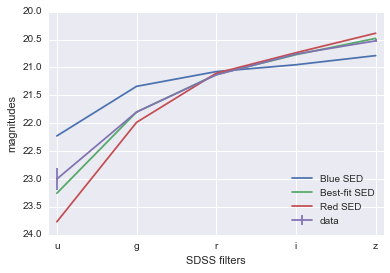

In [43]:
a = readModelSpace('resources/fspsModelSpace/fspsModelSpace_0.06707180291414261.csv')
c = readModelSpace('resources/fspsModelC/fspsModelC_0.06707180291414261.csv')
data = SNIaCam[SNIaCam['CID']==6057][['CID', 'Z', 'u', 'g', 'r', 'i', 'z', 'u uncert',
                                      'g uncert', 'r uncert', 'i uncert', 'z uncert']]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(a[3,8,7,1,:]+c[3,8,7,1], label='Blue SED')
plt.plot(a[0,7,0,5,:]+c[0,7,0,5], label='Best-fit SED')
plt.plot(a[3,0,0,1,:]+c[3,0,0,1], label='Red SED')
# plt.plot(data[['u', 'g', 'r', 'i', 'z']].values[0], label='data')
plt.errorbar([0,1,2,3,4], data[['u', 'g', 'r', 'i', 'z']].values[0], 
             yerr=data[['u uncert', 'g uncert', 'r uncert', 'i uncert', 'z uncert']].values[0],
             label='data')

plt.xlim([-0.1, 4.1])
plt.ylabel('magnitudes')
ax.set_xticklabels(['','u','g','r','i','z'])
plt.xlabel('SDSS filters')
plt.gca().invert_yaxis()
plt.legend(loc=4)

plt.savefig('figures/SN6057 Model Variability.pdf')

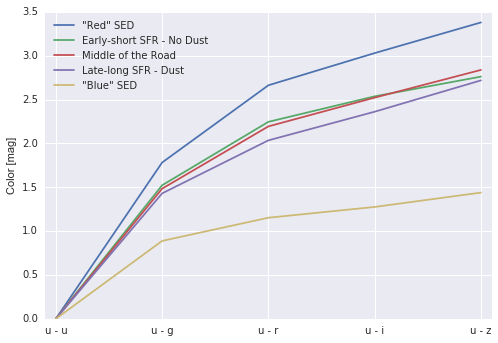

In [125]:
# Looking at the range of possile colors is not needed as much as originally thought.
b = np.tile(a[:,:,:,:,0].reshape(6,9,8,6,1), 5)
color = b - a
# print(a.shape, b.shape, np.array([a[:,:,:,:,0]]).shape)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(color[3,0,0,1,:], label='"Red" SED')# red -- early and short SFH
plt.plot(color[0,0,0,0,:], label='Early-short SFR - No Dust')
plt.plot(color[3,3,3,3,:], label='Middle of the Road')
plt.plot(color[5,8,7,5,:], label='Late-long SFR - Dust')
plt.plot(color[3,8,7,1,:], label='"Blue" SED')# blue -- late and long SFH
# plt.plot(c[1,1,1,1,:], label='2')
plt.legend(loc=2)
plt.ylabel('Color [mag]')
# plt.xlabel('SDSS filters')
ax.set_xlim([-0.1, 4.1])
ax.set_xticklabels(['','u - u','u - g','u - r','u - i','u - z'])


## Is the "best-fit" model good?

For a red-elliptical and blue-spriral does the best fit SED match the SMP?

Here is the data for three galaxies (and some that are cool but missing data).

In [14]:
print(SNIaCam[SNIaCam['CID']==4019][['CID', 'Z', 'u', 'g', 'r', 'i', 'z']]) #small spiral
print(SNIaCam[SNIaCam['CID']==6057][['CID', 'Z', 'u', 'g', 'r', 'i', 'z']]) #spiral
print(SNIaCam[SNIaCam['CID']==14279][['CID', 'Z', 'u', 'g', 'r', 'i', 'z']]) #elliptical?
# SNIaCam[SNIaCam['CID']==17886][['u', 'g', 'r', 'i', 'z']] #large elliptical, not in Campbell
# SNIaCam[SNIaCam['CID']==19323][['u', 'g', 'r', 'i', 'z']] # spiral, not in Campbell
# SNIaCam[SNIaCam['CID']==12930][['u', 'g', 'r', 'i', 'z']] # spiral, not in Campbell12930

      CID         Z          u          g          r          i          z
589  4019  0.181404  24.562866  24.381736  23.457668  23.924663  22.944122
      CID         Z          u          g          r          i          z
641  6057  0.067072  23.000477  21.799643  21.133738  20.760076  20.523961
      CID         Z          u          g          r          i         z
89  14279  0.045389  22.300105  20.891803  20.068498  19.685264  19.36628


Here is the "best-fit" models.

In [43]:
#should just read best fit in from disk, but that has not been saved to disk yet.
#`.astype('float') forced the full sig figs to come out
redshift = [SNIaCam[SNIaCam['CID']==4019]['Z'].astype('float').values[0],
            SNIaCam[SNIaCam['CID']==6057]['Z'].astype('float').values[0],
            SNIaCam[SNIaCam['CID']==14279]['Z'].astype('float').values[0]]

fileName = 'resources/fspsModelSpace/fspsModelSpace_{}.csv'.format(redshift[0])
modelMatrix0 = readModelSpace(fileName)
fileName = 'resources/fspsModelChi2/fspsModelChi2_{}.csv'.format(redshift[0])
chiMatrix0 = readModelSpace(fileName)
fileName = 'resources/fspsModelC/fspsModelC_{}.csv'.format(redshift[0])
cMatrix0 = readModelSpace(fileName)
print(np.where(chiMatrix0 == chiMatrix0.min()))

fileName = 'resources/fspsModelSpace/fspsModelSpace_{}.csv'.format(redshift[1])
modelMatrix1 = readModelSpace(fileName)
fileName = 'resources/fspsModelChi2/fspsModelChi2_{}.csv'.format(redshift[1])
chiMatrix1 = readModelSpace(fileName)
fileName = 'resources/fspsModelC/fspsModelC_{}.csv'.format(redshift[1])
cMatrix1 = readModelSpace(fileName)
print(np.where(chiMatrix1 == chiMatrix1.min()))

fileName = 'resources/fspsModelSpace/fspsModelSpace_{}.csv'.format(redshift[2])
modelMatrix2 = readModelSpace(fileName)
fileName = 'resources/fspsModelChi2/fspsModelChi2_{}.csv'.format(redshift[2])
chiMatrix2 = readModelSpace(fileName)
fileName = 'resources/fspsModelC/fspsModelC_{}.csv'.format(redshift[2])
cMatrix2 = readModelSpace(fileName)
print(np.where(chiMatrix2 == chiMatrix2.min()))

(array([5]), array([3]), array([4]), array([0]))
(array([0]), array([7]), array([0]), array([5]))
(array([1]), array([3]), array([1]), array([4]))


For these three galaxies, lets look at how their best fit SED compares to the model. 

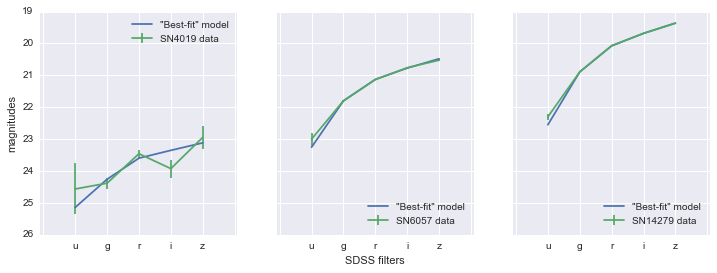

In [44]:
#lets make one figure with 3 plots. Currently failing.
# fig = plt.figure('Combined "Best-fit" Models')
fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,4))

ax[0].plot(modelMatrix0[5,3,4,0,:]+cMatrix0[5,3,4,0], label='"Best-fit" model')
# ax[0].plot(SNIaCam[SNIaCam['CID']==4019][['u', 'g', 'r', 'i', 'z']].values[0], label='SN4019 data')
ax[0].errorbar([0,1,2,3,4], SNIaCam[SNIaCam['CID']==4019][['u', 'g', 'r', 'i', 'z']].values[0],
               yerr=SNIaCam[SNIaCam['CID']==4019][['u uncert', 'g uncert', 'r uncert', 'i uncert', 'z uncert']].values[0],
               label='SN4019 data')
ax[0].set_xticklabels(['','','u','g','r','i','z'])
ax[0].legend()
ax[0].set_aspect(1)

ax[1].plot(modelMatrix1[0,7,0,5,:]+cMatrix1[0,7,0,5], label='"Best-fit" model')
# ax[1].plot(SNIaCam[SNIaCam['CID']==6057][['u', 'g', 'r', 'i', 'z']].values[0], label='SN6057 data')
ax[1].errorbar([0,1,2,3,4], SNIaCam[SNIaCam['CID']==6057][['u', 'g', 'r', 'i', 'z']].values[0],
               yerr=SNIaCam[SNIaCam['CID']==6057][['u uncert', 'g uncert', 'r uncert', 'i uncert', 'z uncert']].values[0],
               label='SN6057 data')
ax[1].set_xticklabels(['','','u','g','r','i','z'])
ax[1].legend(loc=4)
ax[1].set_aspect(1)

ax[2].plot(modelMatrix2[1,3,1,4,:]+cMatrix2[1,3,1,4], label='"Best-fit" model')
# ax[2].plot(SNIaCam[SNIaCam['CID']==14279][['u', 'g', 'r', 'i', 'z']].values[0], label='SN14279 data')
ax[2].errorbar([0,1,2,3,4], SNIaCam[SNIaCam['CID']==14279][['u', 'g', 'r', 'i', 'z']].values[0],
           yerr=SNIaCam[SNIaCam['CID']==14279][['u uncert', 'g uncert', 'r uncert', 'i uncert', 'z uncert']].values[0],
           label='SN14279 data')
ax[2].set_xticklabels(['','','u','g','r','i','z'])
ax[2].legend(loc=4)
ax[2].set_aspect(1)

ax[0].invert_yaxis()
ax[0].set_ylabel('magnitudes')
ax[1].set_xlabel('SDSS filters')


# plt.show()
plt.savefig('figures/Model Data Comparison.pdf')

## Now save the "Best-fit" model parameters.

In [45]:
#get file names
# fileName = 'resources/fspsModelChi2/fspsModelChi2_0.06707180291414261.csv'
fileName = glob('resources/fspsModelChi2/fspsModelChi2*.csv')

#Add space in SNIaCam for fsps best fit parameters: logzsol, tau, sf_start, dust2
SNIaCam['logzsol'] = np.nan
SNIaCam['tau'] = np.nan
SNIaCam['sf_start'] = np.nan
SNIaCam['dust2'] = np.nan

#iterate over all chi^2 files
for f in fileName:
    #read in chi^2 matrix
    chiMatrix = readModelSpace(f)
    
    #find best-fit index and values
    #remove extra glop/dimentions that comes with np.where
    bestFitIndex = np.array(np.where(chiMatrix == chiMatrix.min())).reshape(4)
    bestFitValues = np.array([
            modelParameterSpace['logzsol'][bestFitIndex[0]],
            modelParameterSpace['tau'][bestFitIndex[1]],
            modelParameterSpace['sf_start'][bestFitIndex[2]],
            modelParameterSpace['dust2'][bestFitIndex[3]],
        ])

    #save data to disk
    v = np.vstack((bestFitIndex, bestFitValues))
    redshift = float(f[38:-4])
    saveLocation = 'resources/fspsModelBestFit/fspsModelBestFit_{}.csv'.format(redshift)
    header = "first row is the best fit index and second row is the best fit values for ['logzsol', 'tau', 'sf_star', 'dust2']"
    np.savetxt(saveLocation, v, delimiter=',', header=header)
    
    #save data to SNIaCam
    redshift = float(f[38:-4])
    index = SNIaCam[SNIaCam['Z']==redshift].index.tolist()[0]
    SNIaCam.loc[index, ['logzsol', 'tau', 'sf_start', 'dust2']] = bestFitValues
    
    print('saved: {}'.format(saveLocation))

saved: resources/fspsModelBestFit/fspsModelBestFit_0.04524829983711243.csv
saved: resources/fspsModelBestFit/fspsModelBestFit_0.04538949951529503.csv
saved: resources/fspsModelBestFit/fspsModelBestFit_0.04591529816389084.csv
saved: resources/fspsModelBestFit/fspsModelBestFit_0.05593879893422127.csv
saved: resources/fspsModelBestFit/fspsModelBestFit_0.05738519877195358.csv
saved: resources/fspsModelBestFit/fspsModelBestFit_0.06286069750785828.csv
saved: resources/fspsModelBestFit/fspsModelBestFit_0.06539160013198853.csv
saved: resources/fspsModelBestFit/fspsModelBestFit_0.06707180291414261.csv
saved: resources/fspsModelBestFit/fspsModelBestFit_0.07602299749851227.csv
saved: resources/fspsModelBestFit/fspsModelBestFit_0.07760269939899445.csv
saved: resources/fspsModelBestFit/fspsModelBestFit_0.07881610095500946.csv
saved: resources/fspsModelBestFit/fspsModelBestFit_0.08273419737815857.csv
saved: resources/fspsModelBestFit/fspsModelBestFit_0.0835810974240303.csv
saved: resources/fspsModel

In [15]:
#read in best fit values
def readBestFit(fileName, index=False):
    """
    """
    with open(fileName, 'r') as doc:
        doc.readline()
        secondLine = doc.readline()
        thirdLine = doc.readline()

    #split third line by ',' and save as floats to respective varriales.
    logzsol, tau, sf_start, dust2 = np.array(re.split(r',', thirdLine), dtype=float)
    return logzsol, tau, sf_start, dust2

fileName = 'resources/fspsModelBestFit/fspsModelBestFit_0.06707180291414261.csv'
print(readBestFit(fileName))

(-0.88, 8.0, 0.0, 1.5)


------

# Start Comparing Varriables

The main comparison will be HR vs Stellar population Age. We may also use SN Ia varriables like `color`, `stretch`, or $\Delta m_{15}$. Other stellar population paramteters may be mass (from r band magnitude) or mass from the fitting constant parameter `c`.

## Clacualte Ages (and other local poperties)

In [63]:
def calculateMassAge(z, sf_start, tau):
    """Calculate the mass weighted age as described by Gupta 2011 equatoin 3.
    Requires `scipy.inegrate` to be importate as well as your favorate cosmology to be in 
    `cosmo` such as: `from astropy.cosmology import WMAP9 as cosmo` or 
    `from astropy.cosmology import FlatLambdaCDM` `cosmo = FlatLambdaCDM(H0=70, Om0=0.27)`. 
    The SFH model is a basic $\tau$-model with NO constant SF NOR an instantanious burst.
    
    # Parameters
    
    z : float
        The redshift of the given stellar population. 
    
    sf_start : float
        The start time of the star formation in Gyr from the start of the Universe.
        
    tau : float
        The e-folding time in Gyr of the $\tau$-model of SF.
        
    # Returns
    
    age : float
        The computed mass weighted age.
    """
    
    ageOfUniverse = cosmo.age(z)
    lengthOfSF = ageOfUniverse.to('Gyr').value - sf_start
    
    #we only need to integrate over the burst (not the zero SF at the start)
    #because the `lenghtOfSF` already accounts of `sf_start`.
    #therefore remove if states. Its commented out for future referance on how to do this,
    #eventhough it is not needed here.
    sfFunc = lambda t: np.e**(-t/tau) #if t >= sf_start else 0
    sfTFunc = lambda t: t*sfFunc(t)
    
    numerator = integrate.quad(sfTFunc, 0, lengthOfSF)[0]
    denominator = integrate.quad(sfFunc, 0, lengthOfSF)[0]
    x = np.linspace(0, lengthOfSF, 30)
    y = np.array([])

    return lengthOfSF - numerator/denominator

In [111]:
#old method of reading in Best-fit values
# fileName = 'resources/fspsModelBestFit/fspsModelBestFit_0.06707180291414261.csv'
# fileNames = glob('resources/fspsModelBestFit/fspsModelBestFit_*.csv')
# for fileName in fileNames:
#     logzsol, tau, sf_start, dust2 = readBestFit(fileName)
#     redshift = float(fileName[44:-4])
#     print(calculateMassAge(redshift, sf_start, tau))

In [202]:
holding = SNIaCam[SNIaCam['tau'].notnull()][['Z','sf_start','tau']].values
i = holding[0]
redshift, sf_start, tau = i

def calcualteAgeUncert(redshift, sf_start, tau):
    """
    """
    #get chi^2 matrix
    f = 'resources/fspsModelChi2/fspsModelChi2_{}.csv'.format(redshift)
    chiMatrix = readModelSpace(f)

    #get indexies
    bestFitIndex = np.array(np.where(chiMatrix == chiMatrix.min())).reshape(4)
    logzsol_index = bestFitIndex[0]
    tau_index = bestFitIndex[1]
    sf_start_index = bestFitIndex[2]
    dust2_index = bestFitIndex[3]
    
    #calculate GoF
    GoF = np.e**(-chiMatrix.min()/2.0)

    #calculate delta age
    age = calculateMassAge(redshift, sf_start, tau)
    dAge = np.array([])


    #get +`sf_start`
    if sf_start_index < (len(modelParameterSpace['sf_start'])-1):
        sf_start_plus = modelParameterSpace['sf_start'][sf_start_index+1]
        dAge = np.append(dAge,
                         age - calculateMassAge(redshift, sf_start_plus, tau))
    #get -`sf_start`
    if sf_start_index > 0:
        sf_start_minus = modelParameterSpace['sf_start'][sf_start_index-1]
        dAge = np.append(dAge,
                         age - calculateMassAge(redshift, sf_start_minus, tau))

    #get +`tau`
    if tau_index < (len(modelParameterSpace['tau'])-1):
        tau_plus = modelParameterSpace['tau'][tau_index+1]
        dAge = np.append(dAge,
                         age - calculateMassAge(redshift, sf_start, tau_plus))
    #get -`tau`
    if tau_index > 0:
        tau_minus = modelParameterSpace['tau'][tau_index-1]
        dAge = np.append(dAge,
                         age - calculateMassAge(redshift, sf_start, tau_minus))  
    
    return np.sqrt(np.mean(np.square(dAge*np.e**(-5/2)/GoF)))

calcualteAgeUncert(redshift, sf_start, tau)

2.8975061250538388

In [192]:
#new method of getting values from `SNIaCam`
SNIaCam['age'] = np.nan
SNIaCam['age uncert'] = np.nan

#get redshift, sf_start, and tau values
holding = SNIaCam[SNIaCam['tau'].notnull()][['Z','sf_start','tau']].values
k = 0
for i in holding:
    k += 1
    #unpack varriables
    redshift, sf_start, tau = i
    
    #calculate age
    age = calculateMassAge(redshift, sf_start, tau)
    
    #calculate uncertainty
    ageUncert = calcualteAgeUncert(redshift, sf_start, tau)

    #save to `SNIaCam`
    index = SNIaCam[SNIaCam['Z']==i[0]].index.tolist()[0]
    SNIaCam.loc[index, ['age','age uncert']] = np.array([age, ageUncert])

SNIaCam[SNIaCam['age'].notnull()][['age', 'age uncert']].describe()

,age,age uncert
count,569.000000,5.690000e+02
mean,6.269976,4.207067e+47
std,2.416914,1.003542e+49
min,0.239766,3.402647e-02
25%,4.689738,1.173761e-01
50%,6.804897,3.928252e-01
75%,7.859190,5.250415e+00
max,13.008580,2.393821e+50


(0, 13.7)

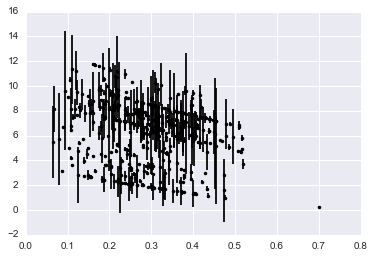

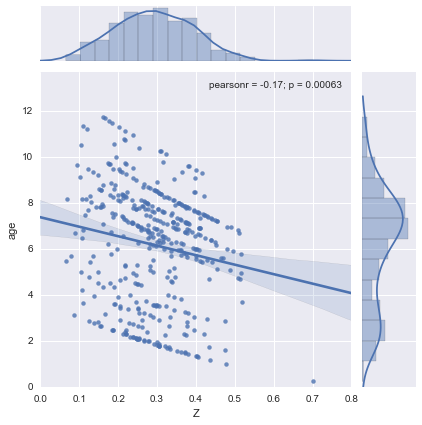

In [234]:
#only plot data that has ALL of redshift, age, and age uncert
plotData = SNIaCam[np.all(SNIaCam[['Z', 'age', 'age uncert']].notnull(), axis=1)]
#only plot data where age uncertity is less then 13 Gry
plotData = plotData[plotData['age uncert'] < 5]
# np.all(SNIaCam[['Z', 'age', 'age uncert']].notnull(), axis=1)
plt.errorbar(plotData['Z'], plotData['age'], yerr=plotData['age uncert'], fmt='k.')
# sns.regplot('Z', 'age', data=plotData)
sns.jointplot('Z', 'age', data=plotData, kind='reg')
plt.xlim([0,0.8])
plt.ylim([0, 13.7])

In [173]:
chi=np.array([0,1,4,5,20,50])
np.e**(-chi/2)
# np.e**(-4/2) - np.e**(-5/2)

0.0532502846127139

In [108]:
from scipy.stats import gmean

In [144]:
f = 'resources/fspsModelChi2/fspsModelChi2_0.06707180291414261.csv'
chiMatrix = readModelSpace(f)
    
#find best-fit index and values
#remove extra glop/dimentions that comes with np.where
bestFitIndex = np.array(np.where(chiMatrix == chiMatrix.min())).reshape(4)
# bestFitValues = np.array([
#         modelParameterSpace['logzsol'][bestFitIndex[0]],
#         modelParameterSpace['tau'][bestFitIndex[1]],
#         modelParameterSpace['sf_start'][bestFitIndex[2]],
#         modelParameterSpace['dust2'][bestFitIndex[3]],
#     ])

np.e**(-chiMatrix[bestFitIndex[0], bestFitIndex[1], bestFitIndex[2], bestFitIndex[3]]/2)
chiMatrix.shape

(6, 9, 8, 6)

In [286]:
#Calculate HR
#use Campbell's $\Lambda$CDM and H$_{0}$ from SH0ES: H = 73.8 ± 2.4kms−1 Mpc−1, Ωm = 0.24
SNIaCam['HR'] = np.nan
CampbellCosmo = FlatLambdaCDM(H0=73.8, Om0=0.24)
for i, redshift in enumerate(SNIaCam['Z']):
    #`.decompose()`: not sure why astropy.units is not automatically going to a dimentionsless unit
    mu_from_z = 5*np.log10((CampbellCosmo.luminosity_distance(redshift)/(10*u.pc)).decompose())
    SNIaCam.loc[i, ['HR']] = SNIaCam.loc[i, ['MU_MB']].values[0] - mu_from_z
SNIaCam['HR'].describe()

count    752.000000
mean      -0.013508
std        0.276118
min       -1.027740
25%       -0.178808
50%       -0.017524
75%        0.141463
max        1.377882
Name: HR, dtype: float64

In [366]:
from scipy.stats import spearmanr

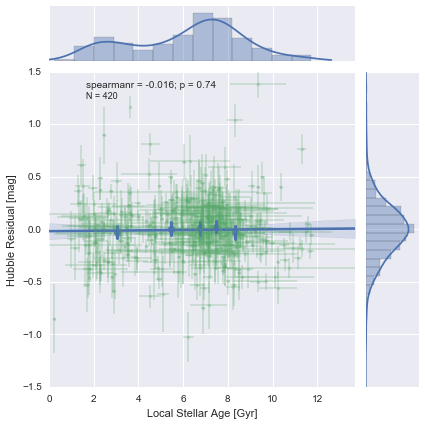

In [464]:
plotData = SNIaCam[np.all(SNIaCam[['Z', 'age', 'age uncert', 'HR', 'MU_ERR']].notnull(), axis=1)]
plotData = plotData[plotData['age uncert'] < 4]
fig = plt.figure()
# plt.errorbar(plotData['age'], plotData['HR'], xerr=plotData['age uncert'], fmt='.', alpha=0.2)
sns.jointplot('age', 'HR', data=plotData, 
              kind='reg', x_bins=5, stat_func=spearmanr,# annot_kws=dict(stat="r"),
              xlim=(0,13.7), ylim=(-1.5, 1.5)) #with histograms
plt.errorbar(plotData['age'], plotData['HR'],yerr=plotData['MU_ERR'], xerr=plotData['age uncert'],
             fmt='.', alpha=0.25)
plt.text(1.65, 1.25, 'N = {}'.format(len(plotData)), fontsize=9)
# sns.regplot('age', 'HR', data=plotData,  x_bins=4, truncate=True)  #binned data
plt.xlabel('Local Stellar Age [Gyr]')
plt.ylabel('Hubble Residual [mag]')
plt.savefig('figures/HRvAge.pdf')

In [453]:
len(plotData)

420

KeyError: 0

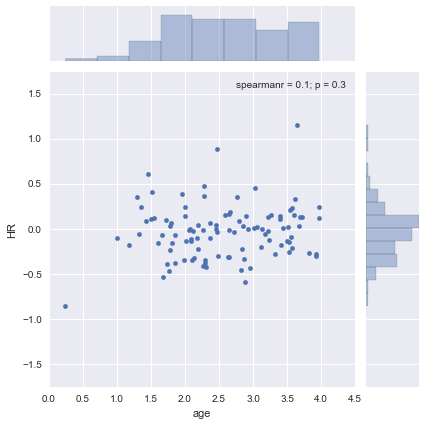

In [414]:
plotData = SNIaCam[np.all(SNIaCam[['Z', 'age', 'age uncert', 'HR', 'MU_ERR']].notnull(), axis=1)]
plotData = plotData[plotData['age uncert'] < 4]
plotDataYoung = plotData[plotData['age'] < 4]
plotDataOld = plotData[plotData['age'] >= 4]
fig = plt.figure()
# plt.errorbar(plotData['age'], plotData['HR'], xerr=plotData['age uncert'], fmt='.', alpha=0.2)
sns.jointplot('age', 'HR', data=plotDataYoung,# hue='Z',
#               kind='reg', x_bins=4, 
              stat_func=spearmanr,# annot_kws=dict(stat="r"),
              xlim=(0,4.5), ylim=(-1.75, 1.75)) #with histograms
# sns.jointplot('age', 'HR', data=plotDataOld, 
# #               kind='reg', x_bins=4, 
#               stat_func=spearmanr,# annot_kws=dict(stat="r"),
#               xlim=(0,13.7), ylim=(-1.75, 1.75)) #with histograms
plt.errorbar(plotDataYoung['age'], plotDataYoung['HR'], yerr=plotDataYoung['MU_ERR'], xerr=plotDataYoung['age uncert'])#,
#              fmt='.', alpha=0.25)
# plt.xlabel('Local Stellar Age [Gyr]')
# plt.ylabel('Hubble Residual')

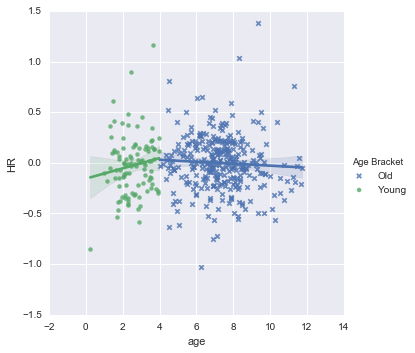

In [450]:
# for i in SNIaCam.index:
#     print(i)
#     if np.isnan(i['age'].values[0]):
#         print('is nan')
#     break
plotData['Age Bracket'] = 'Young'
# SNIaCam[SNIaCam['age'] < 4]['Age Bracket'] = 'Young'
plotData['Age Bracket'] = plotData['Age Bracket'].where(plotData['age']<4, other='Old')
# SNIaCam['Age Bracket'] = SNIaCam['Age Bracket'].where(np.isnan(SNIaCam['age']), other=np.nan)
# SNIaCam['Age Bracket'].describe()
sns.lmplot(x="age", y="HR", hue="Age Bracket", data=plotData, truncate=True, markers=['x','o'])
# (sns.jointplot('age', 'HR', data=plotDataYoung,
# #               kind='reg', x_bins=4, 
#               stat_func=spearmanr,# annot_kws=dict(stat="r"),
#               xlim=(0,4.5), ylim=(-1.75, 1.75))
#              .plot_lmp(x="age", y="HR", hue="Age Bracket", data=plotData, truncate=True))

# Scratch Area!

In [411]:
len(plotDataYoung['age uncert'])

103

In [251]:
SNIaCam[SNIaCam['CID']==762][['CID', 'MU', 'MU_MB']]

,CID,MU,MU_MB
691,762,39.895802,39.907307


In [23]:
SNIaCam.columns

Index(['CID', 'Z', 'Z_ERR', 'SN_RA', 'SN_DEC', 'GAL_RA', 'GAL_DEC',
       'HOST_OBJID', 'X0', 'X0_ERR', 'X1', 'X1_ERR', 'COLOR', 'COLOR_ERR',
       'C01', 'C00', 'C11', 'C22', 'C02', 'C12', 'MU', 'MU_MB', 'MU_ERR', 'u',
       'u uncert', 'g', 'g uncert', 'r', 'r uncert', 'i', 'i uncert', 'z',
       'z uncert'],
      dtype='object')

In [26]:
SNIaCam[SNIaCam['CID']==4019][['MU', 'MU_MB']]

,MU,MU_MB
589,39.5676,39.578056


In [40]:
#4019, 6057, 14279
SNIaCam[SNIaCam['CID']==4019]#['fsps chi2']

,CID,Z,Z_ERR,SN_RA,SN_DEC,GAL_RA,GAL_DEC,HOST_OBJID,X0,X0_ERR,...,g,g uncert,r,r uncert,i,i uncert,z,z uncert,fsps chi2,fsps const
589,4019,0.181404,0.000046,1.26181,1.14542,1.26181,1.145417,1237657192516354264,0.000074,0.000003,...,24.381736,0.175119,23.457668,0.122732,23.924663,0.278764,22.944122,0.363262,NaN,NaN


In [ ]:
bestFitIndex = np.array(np.where(chiMatrix == chiMatrix.min())).reshape(4)
SNIaCam[SNIaCam['Z']==redshift]['fsps const'] = cMatrix[bestFitIndex]

In [59]:
redshift
chiMatrix.min()
SNIaCam[SNIaCam['Z']==redshift]
SNIaCam[SNIaCam['Z']==redshift]['fsps chi2']
# SNIaCam.loc[i, ['u', 'u uncert', 'g', 'g uncert', 'r', 'r uncert', 'i', 'i uncert', 'z', 'z uncert']] = magitudes
index = SNIaCam[SNIaCam['Z']==redshift].index.tolist()[0]
SNIaCam.loc[index, ['fsps chi2']] = 1
# SNIaCam[SNIaCam['Z']==redshift]['fsps chi2'] = 1
# SNIaCam[SNIaCam['Z']==redshift]['fsps chi2'] = chiMatrix.min()
SNIaCam[SNIaCam['Z']==redshift]['fsps chi2']

589    1.0
Name: fsps chi2, dtype: float64